In [2]:
%load_ext autoreload
%load_ext nb_black
%autoreload 2

<IPython.core.display.Javascript object>

In [3]:
import os

from tensorflow import keras
from toai.imports import *

from data import DataContainer
from image import *
from image_learner import ImageLearner
from transformations import (
    ImageParser,
    ImageCropTransformation,
    ImageLRFlpTransformation,
)
import tensorflow_addons as tfa
from triplet_loss import triplet_loss_adapted_from_tf
from image_utils import show_distances
from sklearn.decomposition import PCA

/home/martynas/ml/.venv/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


<IPython.core.display.Javascript object>

In [4]:
tf.debugging.set_log_device_placement(False)
gpus = tf.config.experimental.list_physical_devices("GPU")
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            print(gpu)
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices("GPU")
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
1 Physical GPUs, 1 Logical GPUs


<IPython.core.display.Javascript object>

In [5]:
def invocation_counter(layer_count):
    def decorator(function):
        def wrapper(*args, **kwargs):
            def no_op(*args, **kwargs):
                pass

            wrapper.called += 1

            if wrapper.called > (layer_count * 2):
                return function(*args, **kwargs)
            else:
                return no_op(*args, **kwargs)

        wrapper.called = 0
        wrapper.__name__ = function.__name__
        return wrapper

    return decorator

<IPython.core.display.Javascript object>

In [6]:
DATA_DIR = Path("data")
TEMP_DIR = Path("temp")
DATA_DIR.mkdir(parents=True, exist_ok=True)
TEMP_DIR.mkdir(parents=True, exist_ok=True)

<IPython.core.display.Javascript object>

In [7]:
TRAIN_DIR = DATA_DIR / "train"
images = [
    str(TRAIN_DIR / label_dir / val)
    for label_dir in os.listdir(TRAIN_DIR)
    for val in os.listdir(TRAIN_DIR / label_dir)
]

<IPython.core.display.Javascript object>

In [8]:
train_df = pd.DataFrame()
train_df["path"] = images
train_df["label"] = train_df["path"].apply(lambda path: path.split("/")[2])

<IPython.core.display.Javascript object>

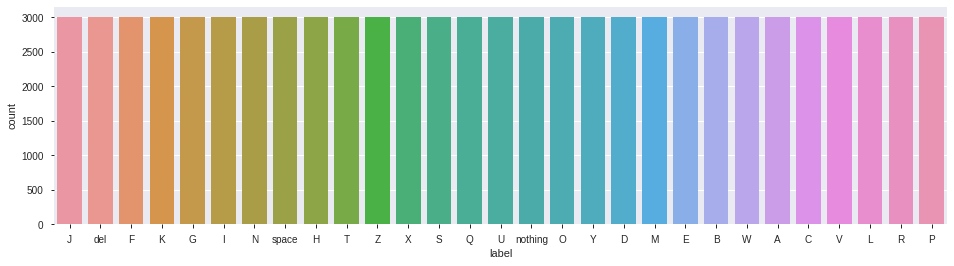

<IPython.core.display.Javascript object>

In [9]:
plt.figure(figsize=(16, 4))
sns.countplot(x="label", data=train_df)

In [10]:
TEST_DIR = DATA_DIR / "test"
test_images = [
    str(TEST_DIR / label_dir / val)
    for label_dir in os.listdir(TEST_DIR)
    for val in os.listdir(TEST_DIR / label_dir)
]

<IPython.core.display.Javascript object>

In [11]:
test_df = pd.DataFrame()
test_df["path"] = test_images
test_df["label"] = test_df["path"].apply(lambda path: path.split("/")[2])

<IPython.core.display.Javascript object>

In [12]:
test_df.head()

,path,label
0,data/test/J/J0029_test.jpg,J
1,data/test/J/J0005_test.jpg,J
2,data/test/J/J0017_test.jpg,J
3,data/test/J/J0021_test.jpg,J
4,data/test/J/J0024_test.jpg,J


<IPython.core.display.Javascript object>

In [13]:
test_df.shape

(870, 2)

<IPython.core.display.Javascript object>

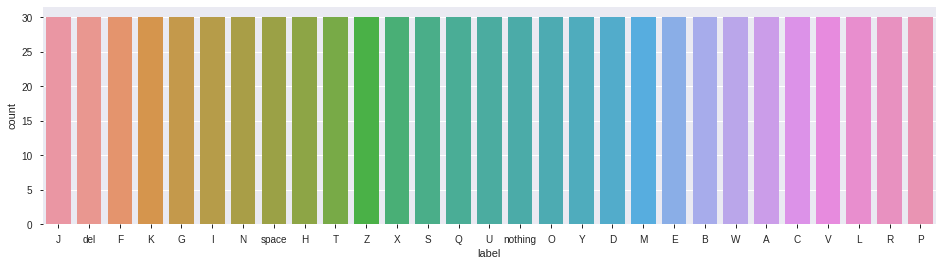

<IPython.core.display.Javascript object>

In [14]:
plt.figure(figsize=(16, 4))
sns.countplot(x="label", data=test_df)

In [15]:
IMG_DIMS = (100, 100, 3)

<IPython.core.display.Javascript object>

In [16]:
train_data, validation_data = train_test_split(train_df, test_size=0.2)

<IPython.core.display.Javascript object>

In [17]:
test_data = test_df.copy()

<IPython.core.display.Javascript object>

In [18]:
[data.shape for data in [train_data, validation_data]]

[(69600, 2), (17400, 2)]

<IPython.core.display.Javascript object>

In [21]:
base_config = ImageDatasetConfig(
    img_dims=IMG_DIMS,
    batch_size=16,
    preprocess_pipeline=[ImageParser(), ImageCropTransformation(IMG_DIMS)],
)

train_dataset = ImageDataset(
    base_config.copy(preprocess_pipeline=[ImageLRFlpTransformation()], shuffle=True)
).build_from_df(train_data, "path", "label")

data_container = DataContainer(
    train=train_dataset,
    validation=ImageDataset(
        base_config.copy(preprocess_pipeline=[ImageLRFlpTransformation()])
    )
    .with_label_map(train_dataset.label_map)
    .build_from_df(validation_data, "path", "label"),
    test=ImageDataset(
        base_config.copy(preprocess_pipeline=[ImageCropTransformation(IMG_DIMS)])
    )
    .with_label_map(train_dataset.label_map)
    .build_from_df(test_data, "path", "label"),
)

<IPython.core.display.Javascript object>

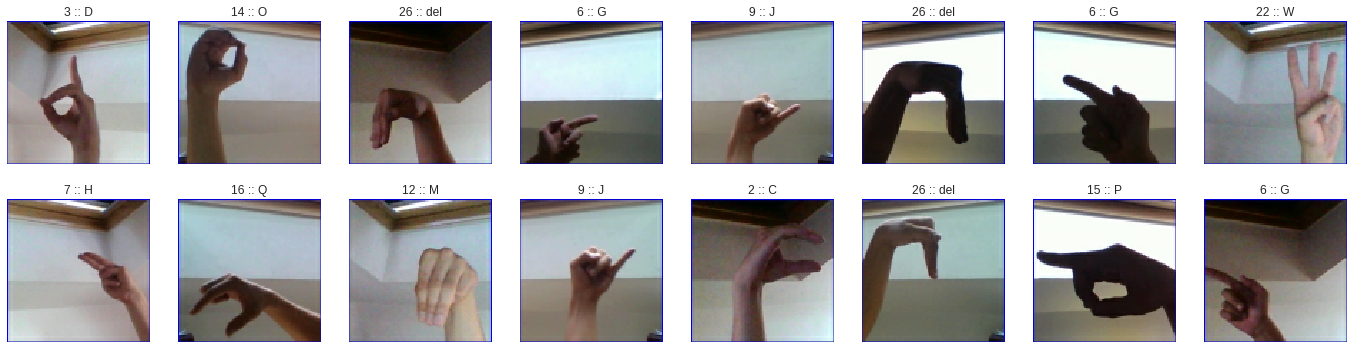

<IPython.core.display.Javascript object>

In [22]:
data_container.validation.show()

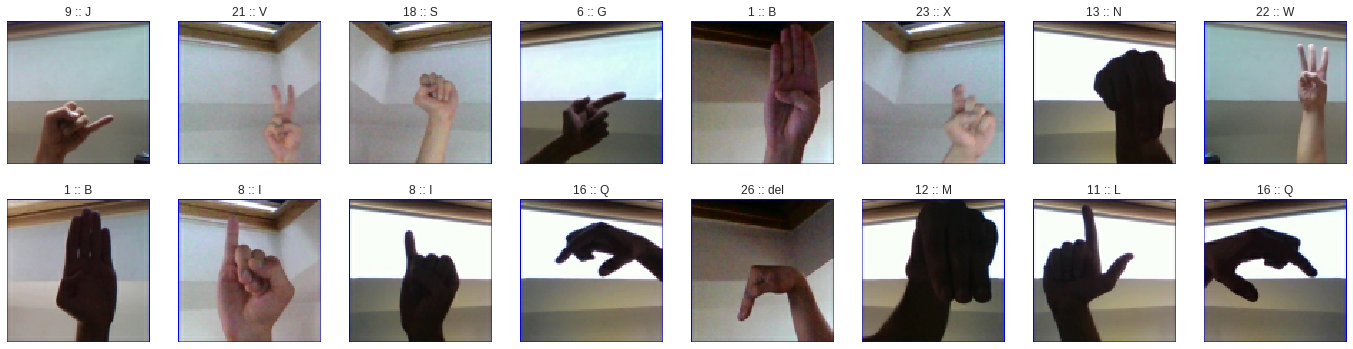

<IPython.core.display.Javascript object>

In [18]:
data_container.validation.show()

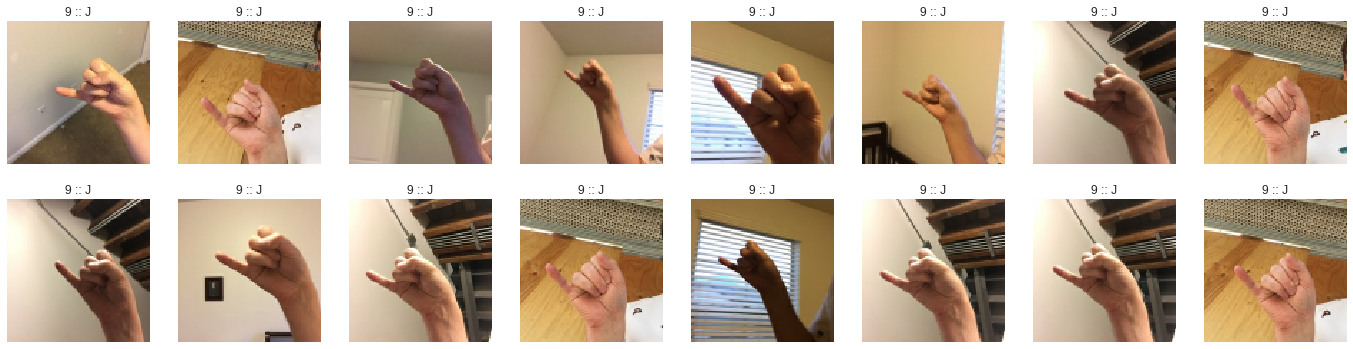

<IPython.core.display.Javascript object>

In [82]:
data_container.test.show()

In [23]:
learner = ImageLearner(
    model_path=Path(TEMP_DIR / "xception_v2"),
    data=data_container,
    base_model=keras.applications.Xception,
    input_shape=IMG_DIMS,
    dropout=0.3,
    activation=keras.activations.softmax,
)

Existing model data path exists
Loading architecture and weights from temp/xception_v2
Model loaded successfully


<IPython.core.display.Javascript object>

In [293]:
learner.auto_train(
    easing_epochs=0,
    epochs=1,
    optimizer=keras.optimizers.Adam,
    lr=1e-4,
    loss=keras.losses.sparse_categorical_crossentropy,
    metrics=[keras.metrics.sparse_categorical_accuracy],
)

Starting model training
Train for 4350 steps, validate for 1088 steps
4350/4350 [==============================] - 243s 56ms/step - loss: 0.0279 - sparse_categorical_accuracy: 0.9948 - val_loss: 0.0070 - val_sparse_categorical_accuracy: 0.9997
Loading weights only from temp/xception_v2/weights.h5
Model loaded successfully
Model training completed


<IPython.core.display.Javascript object>

17400/17400 [==============================] - 141s 8ms/step


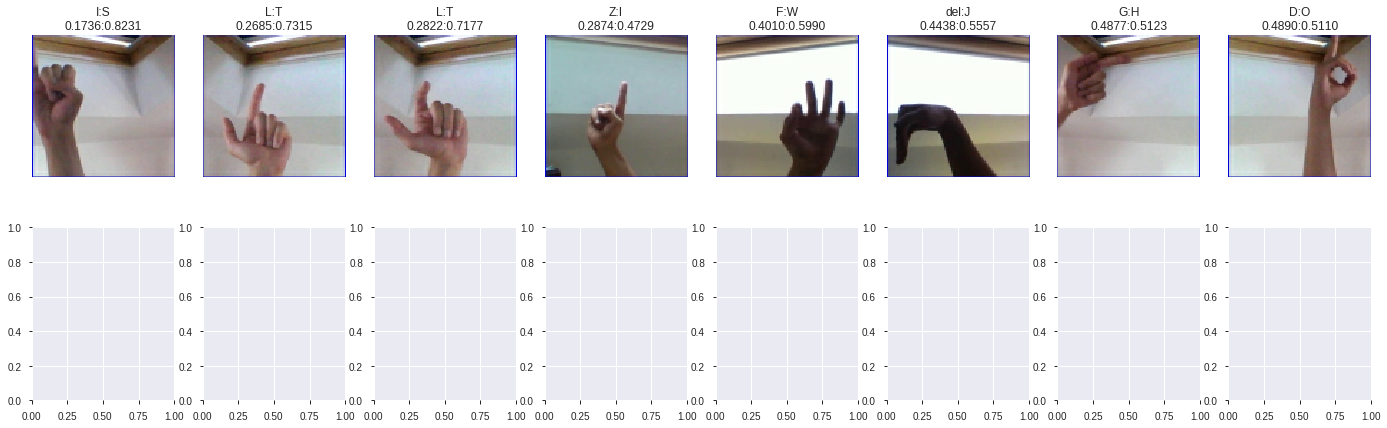

<IPython.core.display.Javascript object>

In [180]:
learner.show_predictions(mode="validation", correct=False)

In [101]:
learner.evaluate_dataset(mode="validation")

[0.014341398129438269, 0.9987356]

<IPython.core.display.Javascript object>

In [102]:
learner.evaluate_dataset(mode="test")

[5.960159396041523, 0.42988506]

<IPython.core.display.Javascript object>

In [280]:
@invocation_counter(len(learner.model.layers))
def short_summary(line):
    print(line)


learner.model.summary(print_fn=short_summary)

block14_sepconv2 (SeparableConv (None, 3, 3, 2048)   3159552     block14_sepconv1_act[0][0]       
__________________________________________________________________________________________________
block14_sepconv2_bn (BatchNorma (None, 3, 3, 2048)   8192        block14_sepconv2[0][0]           
__________________________________________________________________________________________________
block14_sepconv2_act (Activatio (None, 3, 3, 2048)   0           block14_sepconv2_bn[0][0]        
__________________________________________________________________________________________________
global_average_pooling2d_12 (Gl (None, 2048)         0           block14_sepconv2_act[0][0]       
__________________________________________________________________________________________________
global_max_pooling2d_12 (Global (None, 2048)         0           block14_sepconv2_act[0][0]       
__________________________________________________________________________________________________
concatenat

<IPython.core.display.Javascript object>

In [181]:
learner.model = keras.Model(
    inputs=learner.base_model.input, outputs=learner.concat_layer
)

<IPython.core.display.Javascript object>

In [182]:
def calculate_neighbrors(mode: str = "validation"):
    image_embeddings = learner.predict_dataset(mode=mode, verbose=1)
    return sk.neighbors.NearestNeighbors(n_neighbors=11, algorithm="ball_tree").fit(
        image_embeddings
    )

<IPython.core.display.Javascript object>

In [183]:
new_image_index = np.random.randint(len(data_container.validation.x))
new_image_index

3766

<IPython.core.display.Javascript object>

In [187]:
neighbors = calculate_neighbrors()
images = tf.data.Dataset.from_tensor_slices(
    data_container.validation.x[new_image_index : new_image_index + 1]
)
for fun in data_container.validation.config.preprocess_pipeline:
    images = images.map(fun, num_parallel_calls=1)

images = images.batch(1)
new_image_embeddings = learner.model.predict(images)
distances, indices = neighbors.kneighbors(new_image_embeddings)

1088/1088 [==============================] - 20s 18ms/step


<IPython.core.display.Javascript object>

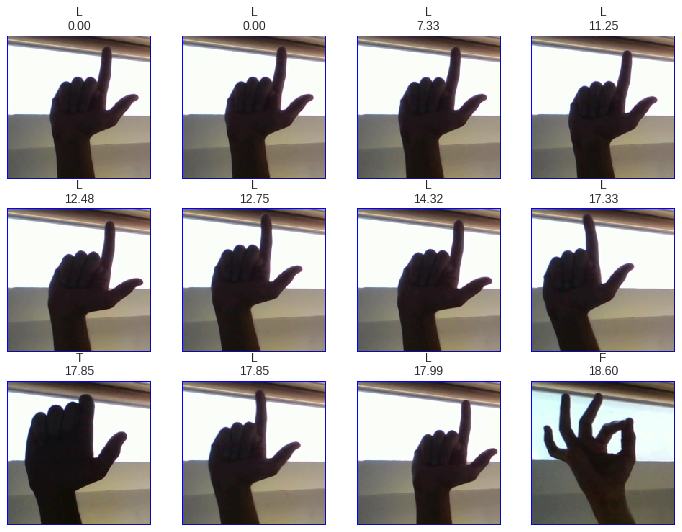

<IPython.core.display.Javascript object>

In [188]:
show_distances(
    data_container.validation,
    new_image_index,
    indices[0].tolist(),
    distances[0].tolist(),
)

In [190]:
new_image_index = np.random.randint(len(data_container.test.x))

<IPython.core.display.Javascript object>

In [191]:
neighbors = calculate_neighbrors(mode="test")
images = tf.data.Dataset.from_tensor_slices(
    data_container.test.x[new_image_index : new_image_index + 1]
)
for fun in data_container.test.config.preprocess_pipeline:
    images = images.map(fun, num_parallel_calls=1)

images = images.batch(1)
new_image_embeddings = learner.model.predict(images)
distances, indices = neighbors.kneighbors(new_image_embeddings)

55/55 [==============================] - 1s 19ms/step


<IPython.core.display.Javascript object>

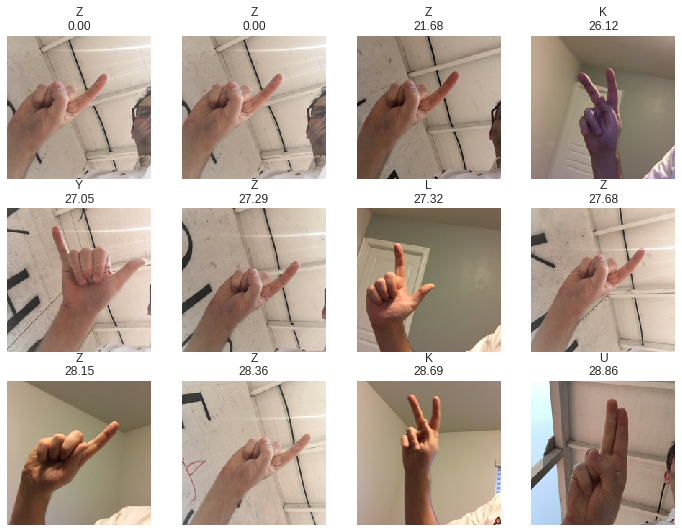

<IPython.core.display.Javascript object>

In [192]:
show_distances(
    data_container.test, new_image_index, indices[0].tolist(), distances[0].tolist()
)

In [295]:
val_emb = learner.predict_dataset()

<IPython.core.display.Javascript object>

In [317]:
test_emb = learner.predict_dataset(mode="test")

<IPython.core.display.Javascript object>

In [327]:
step = 2

<IPython.core.display.Javascript object>

In [318]:
pca = PCA(n_components=2)
decomosed_val_emb = pca.fit_transform(val_emb)
decomposed_test_emb = pca.fit_transform(test_emb)

<IPython.core.display.Javascript object>

/home/martynas/ml/.venv/lib/python3.6/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/home/martynas/ml/.venv/lib/python3.6/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  from ipykernel import kernelapp as app


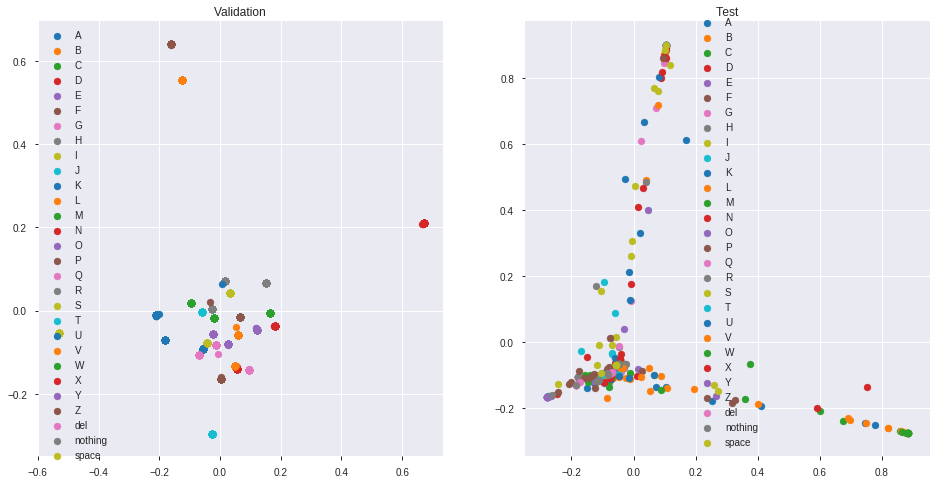

<IPython.core.display.Javascript object>

In [328]:
fig = plt.figure(figsize=(16, 8))
for label in data_container.validation.classes:
    decomosed_val_emb_class = decomosed_val_emb[data_container.validation.y == label]
    decomosed_test_emb_class = decomposed_test_emb[data_container.test.y == label]

    plt.subplot(1, 2, 1)
    plt.scatter(
        decomosed_val_emb_class[::step, 1],
        decomosed_val_emb_class[::step, 0],
        label=str(label),
    )
    plt.title("Validation")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.scatter(
        decomosed_test_emb_class[::step, 1],
        decomosed_test_emb_class[::step, 0],
        label=str(label),
    )
    plt.title("Test")
    plt.legend()

In [24]:
lambda_layer = keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))
learner.model = keras.Model(
    inputs=learner.base_model.input, outputs=lambda_layer(learner.concat_layer)
)

<IPython.core.display.Javascript object>

In [25]:
@invocation_counter(len(learner.model.layers))
def short_summary(line):
    print(line)


learner.model.summary(print_fn=short_summary)

block14_sepconv1_act (Activatio (None, 3, 3, 1536)   0           block14_sepconv1_bn[0][0]        
__________________________________________________________________________________________________
block14_sepconv2 (SeparableConv (None, 3, 3, 2048)   3159552     block14_sepconv1_act[0][0]       
__________________________________________________________________________________________________
block14_sepconv2_bn (BatchNorma (None, 3, 3, 2048)   8192        block14_sepconv2[0][0]           
__________________________________________________________________________________________________
block14_sepconv2_act (Activatio (None, 3, 3, 2048)   0           block14_sepconv2_bn[0][0]        
__________________________________________________________________________________________________
global_average_pooling2d (Globa (None, 2048)         0           block14_sepconv2_act[0][0]       
__________________________________________________________________________________________________
global_max

<IPython.core.display.Javascript object>

In [26]:
learner.auto_train(
    easing_epochs=0,
    epochs=1,
    optimizer=keras.optimizers.Adam,
    lr=1e-3,
    loss=tfa.losses.TripletSemiHardLoss(),
    metrics=[],
)

Starting model training
Train for 4350 steps, validate for 1088 steps
4350/4350 [==============================] - 244s 56ms/step - loss: nan - val_loss: nan
Loading weights only from temp/xception_v2/weights.h5


ValueError: You are trying to load a weight file containing 82 layers into a model with 80 layers.

<IPython.core.display.Javascript object>